In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [9]:
train_path = "data/train.csv"
test_path = "data/test.csv"
sample_path = "data/sample_submission.csv"
data_dict = "data/data_dictionary.csv"

train_data = pd.read_csv(train_path)

In [10]:
data_info_df = pd.read_csv(data_dict)
label_encoder = LabelEncoder()

for index, row in data_info_df.iterrows():
    if row["type"] == "Categorical":
        train_data[row["variable"]] = label_encoder.fit_transform(train_data[row["variable"]])
    else:
        train_data[row["variable"]] = train_data[row["variable"]].fillna(-1)

train_data = train_data.astype("float")
train_data["y"] = transform_survival_probability(train_data)

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.out(x)

In [17]:
X = torch.tensor(train_data.drop(columns=["ID", "y", "efs", "efs_time"]).to_numpy(), dtype=torch.float32)
y = torch.tensor(train_data["y"].to_numpy(), dtype=torch.float32)

In [21]:
model = NeuralNetwork(input_dim=X.shape[1])

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [23]:
def train(model, train_loader, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0
        epoch_loss = 0
        
        for data, label in train_loader:
            pred = model(data)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return loss_history

In [28]:
loss_history = train(model, train_loader, optimizer)

Epoch [1/10], Loss: 0.0433
Epoch [2/10], Loss: 0.0437
Epoch [3/10], Loss: 0.0434
Epoch [4/10], Loss: 0.0419
Epoch [5/10], Loss: 0.0426
Epoch [6/10], Loss: 0.0417
Epoch [7/10], Loss: 0.0435
Epoch [8/10], Loss: 0.0420
Epoch [9/10], Loss: 0.0425
Epoch [10/10], Loss: 0.0429


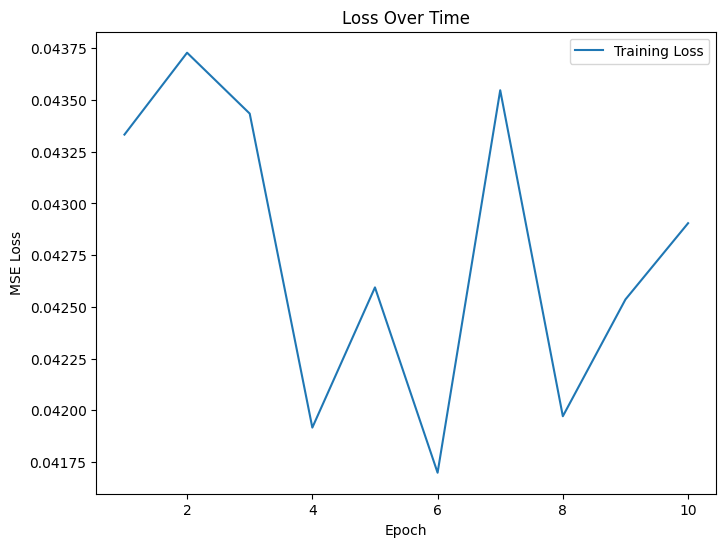

In [29]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()